In [368]:
import os
import torch
import torch.nn as nn
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, Normalize, Compose, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

In [369]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
sample_dir = './samples'


In [370]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

device

device(type='mps')

In [371]:
transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

f_mnist = FashionMNIST(root='./data', train=True, download=True, transform=transform)

In [372]:
img, label = f_mnist[0]
print('Label:', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label: 9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

In [373]:
data_loader = torch.utils.data.DataLoader(dataset=f_mnist,
                                          batch_size=batch_size,
                                          shuffle=True)

In [374]:
discriminator = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)


generator = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

In [375]:
D = discriminator.to(device)
G = generator.to(device)

In [376]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)



In [377]:
D.apply(weights_init)
G.apply(weights_init)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

In [378]:
bce_criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [379]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

In [380]:
def reset_grad(lr=0.0002):
    d_optimizer(lr).zero_grad()
    g_optimizer(lr).zero_grad()

Label: 9


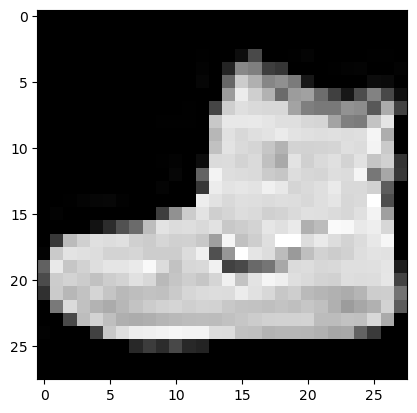

In [381]:
import matplotlib.pyplot as plt

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [382]:
y = G(torch.randn(2, latent_size).to(device))
gen_imgs = denorm(y.reshape((-1, 28, 28)).detach())


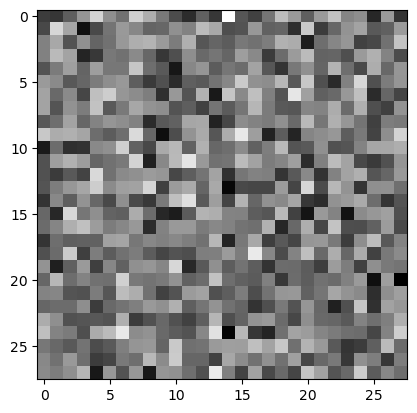

In [383]:
plt.imshow(gen_imgs[0].cpu(), cmap='gray')


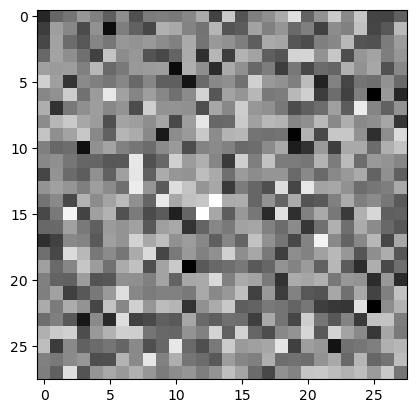

In [384]:
plt.imshow(gen_imgs[1].cpu(), cmap='gray')

In [385]:
def train_generator_discriminator(epoch_num, epoch, total_step, criterion, images):
    real_labels = torch.ones(batch_size, 1).to(device) * 0.9
    fake_labels = torch.zeros(batch_size, 1).to(device) * 0.1

    outputs = D(images + 0.1 * torch.randn_like(images))
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images.detach() + 0.1 * torch.randn_like(fake_images))
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_real + d_loss_fake
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    g_loss = criterion(outputs, real_labels)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    if (epoch_num+1) % 200 == 0:
        print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
              .format(epoch, num_epochs, epoch_num+1, total_step, d_loss.item(), g_loss.item(),
                      real_score.mean().item(), fake_score.mean().item()))

    return g_loss, d_loss, real_score, fake_score, fake_images

In [386]:
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [387]:
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0, 0
    epoch_real_score, epoch_fake_score = 0, 0
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        g_loss, d_loss, real_score, fake_score, fake_images = train_generator_discriminator(i, epoch, total_step, bce_criterion, images)

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_real_score += real_score.mean().item()
        epoch_fake_score += fake_score.mean().item()

        if epoch == 0 and i == 0:
            real_images = images.reshape(images.size(0), 1, 28, 28)
            save_image(denorm(real_images), os.path.join(sample_dir, 'real_images.png'))

    d_losses.append(epoch_d_loss / total_step)
    g_losses.append(epoch_g_loss / total_step)
    real_scores.append(epoch_real_score / total_step)
    fake_scores.append(epoch_fake_score / total_step)


    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

    print(f'Epoch [{epoch+1}/{num_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}, '
          f'D(x): {real_scores[-1]:.2f}, D(G(z)): {fake_scores[-1]:.2f}')


Epoch [0/200], Step [200/600], d_loss: 0.7636, g_loss: 1.3756, D(x): 0.82, D(G(z)): 0.29
Epoch [0/200], Step [400/600], d_loss: 0.6138, g_loss: 2.2404, D(x): 0.85, D(G(z)): 0.17
Epoch [0/200], Step [600/600], d_loss: 0.9407, g_loss: 1.7963, D(x): 0.69, D(G(z)): 0.34
Epoch [1/200], d_loss: 0.8342, g_loss: 1.5271, D(x): 0.78, D(G(z)): 0.30
Epoch [1/200], Step [200/600], d_loss: 0.9082, g_loss: 2.0851, D(x): 0.71, D(G(z)): 0.24
Epoch [1/200], Step [400/600], d_loss: 0.6939, g_loss: 2.0083, D(x): 0.75, D(G(z)): 0.16
Epoch [1/200], Step [600/600], d_loss: 0.8400, g_loss: 2.0580, D(x): 0.75, D(G(z)): 0.27
Epoch [2/200], d_loss: 0.8539, g_loss: 1.8398, D(x): 0.71, D(G(z)): 0.24
Epoch [2/200], Step [200/600], d_loss: 0.8592, g_loss: 1.9940, D(x): 0.67, D(G(z)): 0.17
Epoch [2/200], Step [400/600], d_loss: 0.9075, g_loss: 1.7485, D(x): 0.71, D(G(z)): 0.27
Epoch [2/200], Step [600/600], d_loss: 0.9039, g_loss: 1.7975, D(x): 0.74, D(G(z)): 0.29
Epoch [3/200], d_loss: 0.8627, g_loss: 1.8006, D(x): 

In [388]:
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

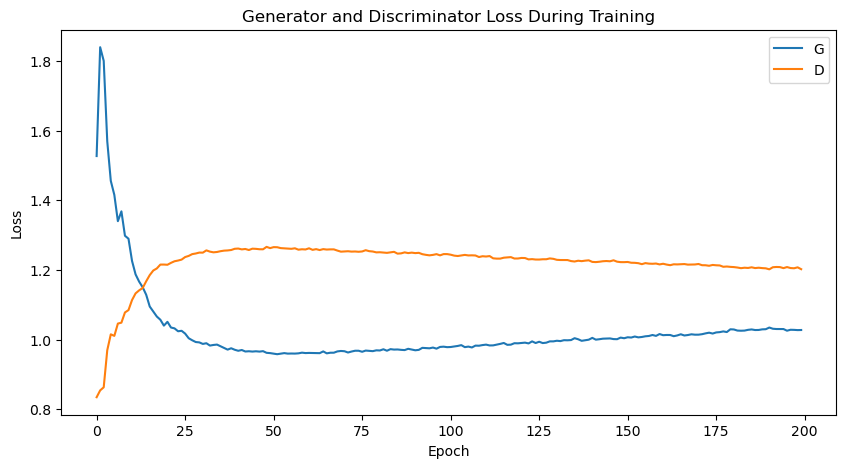

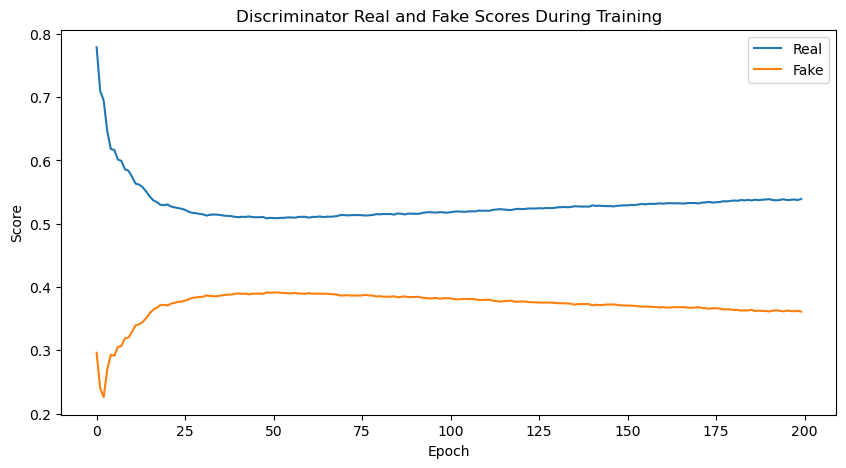

In [389]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Discriminator Real and Fake Scores During Training")
plt.plot(real_scores, label="Real")
plt.plot(fake_scores, label="Fake")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.show()


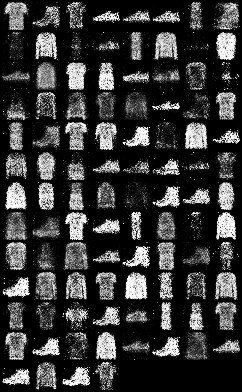

In [390]:
from IPython.display import Image

Image('./samples/fake_images-10.png')

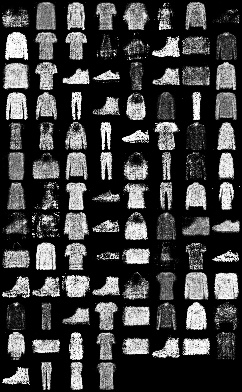

In [391]:
Image('./samples/fake_images-50.png')

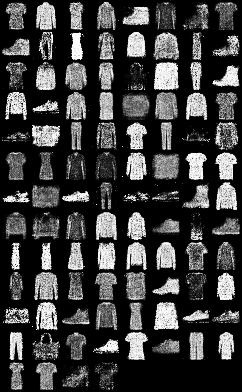

In [392]:
Image('./samples/fake_images-100.png')


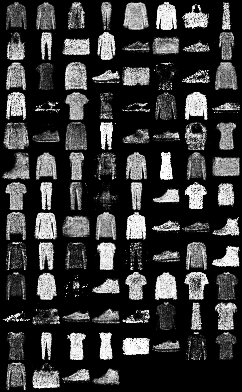

In [393]:
Image('./samples/fake_images-150.png')


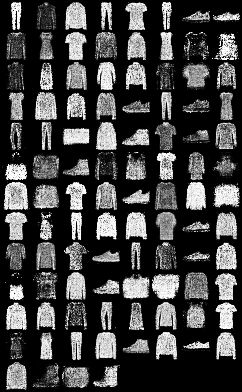

In [394]:
Image('./samples/fake_images-200.png')


In [399]:
G.load_state_dict(torch.load('G.ckpt'))
D.load_state_dict(torch.load('D.ckpt'))

additional_epochs = 100

new_lr = 0.0001

for epoch in range(num_epochs, num_epochs + additional_epochs):
    epoch_d_loss, epoch_g_loss = 0, 0
    epoch_real_score, epoch_fake_score = 0, 0

    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        g_loss, d_loss, real_score, fake_score, fake_images = train_generator_discriminator(i, epoch, total_step, bce_criterion, images)

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_real_score += real_score.mean().item()
        epoch_fake_score += fake_score.mean().item()

    d_losses.append(epoch_d_loss / total_step)
    g_losses.append(epoch_g_loss / total_step)
    real_scores.append(epoch_real_score / total_step)
    fake_scores.append(epoch_fake_score / total_step)

    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    save_image(denorm(fake_images), os.path.join(sample_dir, 'retrained_fake_images-{}.png'.format(epoch+1)))

    print(f'Epoch [{epoch+1}/{num_epochs + additional_epochs}], d_loss: {d_losses[-1]:.4f}, g_loss: {g_losses[-1]:.4f}, '
        f'D(x): {real_scores[-1]:.2f}, D(G(z)): {fake_scores[-1]:.2f}')

/var/folders/8y/qyq16t6549scb0wwphs6rhjm0000gn/T/ipykernel_28196/4114438180.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('G.ckpt'))
/var/

Epoch [200/200], Step [200/600], d_loss: 1.1890, g_loss: 1.0635, D(x): 0.53, D(G(z)): 0.35
Epoch [200/200], Step [400/600], d_loss: 1.2051, g_loss: 1.0779, D(x): 0.53, D(G(z)): 0.36
Epoch [200/200], Step [600/600], d_loss: 1.2540, g_loss: 1.0132, D(x): 0.51, D(G(z)): 0.36
Epoch [201/300], d_loss: 1.2049, g_loss: 1.0269, D(x): 0.54, D(G(z)): 0.36
Epoch [201/200], Step [200/600], d_loss: 1.1886, g_loss: 1.0649, D(x): 0.52, D(G(z)): 0.34
Epoch [201/200], Step [400/600], d_loss: 1.1268, g_loss: 1.0103, D(x): 0.59, D(G(z)): 0.36
Epoch [201/200], Step [600/600], d_loss: 1.2329, g_loss: 1.0062, D(x): 0.57, D(G(z)): 0.39
Epoch [202/300], d_loss: 1.2010, g_loss: 1.0317, D(x): 0.54, D(G(z)): 0.36
Epoch [202/200], Step [200/600], d_loss: 1.1697, g_loss: 1.0410, D(x): 0.54, D(G(z)): 0.34
Epoch [202/200], Step [400/600], d_loss: 1.1490, g_loss: 1.0285, D(x): 0.56, D(G(z)): 0.36
Epoch [202/200], Step [600/600], d_loss: 1.1769, g_loss: 1.0187, D(x): 0.56, D(G(z)): 0.37
Epoch [203/300], d_loss: 1.2025

In [401]:
lsgan_sample_dir = './lsgan_samples'
if not os.path.exists(lsgan_sample_dir):
  os.makedirs(lsgan_sample_dir)

D = discriminator.to(device)
G = generator.to(device)
mse_criterion = nn.MSELoss()

total_step = len(data_loader)

num_epochs = 200

for epoch in range(num_epochs):
  for i, (images, _) in enumerate(data_loader):
      images = images.reshape(batch_size, -1).to(device)

      g_loss, d_loss, real_score, fake_score, fake_images = train_generator_discriminator(i, epoch, total_step, bce_criterion, images)

  if (epoch+1) == 1:
      images = images.reshape(images.size(0), 1, 28, 28)
      save_image(denorm(images), os.path.join(lsgan_sample_dir, 'real_images.png'))

  fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
  save_image(denorm(fake_images), os.path.join(lsgan_sample_dir, 'fake_images-{}.png'.format(epoch+1)))

torch.save(G.state_dict(), 'G_lsgan.ckpt')
torch.save(D.state_dict(), 'D_lsgan.ckpt')

Epoch [0/200], Step [200/600], d_loss: 1.1064, g_loss: 1.1770, D(x): 0.59, D(G(z)): 0.35
Epoch [0/200], Step [400/600], d_loss: 1.1420, g_loss: 1.1599, D(x): 0.57, D(G(z)): 0.35
Epoch [0/200], Step [600/600], d_loss: 1.1897, g_loss: 1.0973, D(x): 0.54, D(G(z)): 0.33
Epoch [1/200], Step [200/600], d_loss: 1.2059, g_loss: 1.0510, D(x): 0.56, D(G(z)): 0.37
Epoch [1/200], Step [400/600], d_loss: 1.1379, g_loss: 1.1310, D(x): 0.58, D(G(z)): 0.35
Epoch [1/200], Step [600/600], d_loss: 1.2160, g_loss: 1.0508, D(x): 0.53, D(G(z)): 0.34
Epoch [2/200], Step [200/600], d_loss: 1.1475, g_loss: 1.1363, D(x): 0.58, D(G(z)): 0.36
Epoch [2/200], Step [400/600], d_loss: 1.2240, g_loss: 1.0396, D(x): 0.52, D(G(z)): 0.35
Epoch [2/200], Step [600/600], d_loss: 1.2290, g_loss: 1.1458, D(x): 0.55, D(G(z)): 0.38
Epoch [3/200], Step [200/600], d_loss: 1.1705, g_loss: 1.0316, D(x): 0.55, D(G(z)): 0.35
Epoch [3/200], Step [400/600], d_loss: 1.1557, g_loss: 1.0579, D(x): 0.53, D(G(z)): 0.31
Epoch [3/200], Step [

* I had to initialize weights as my model was collapsing to a single point and not learning anything. This was creating black images with nothing in them.
* LSGAN is producing better results than GAN and has a better convergence rate.